<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/Copy_of_aml_2324_w6_webinar_bike_rides_pdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Rides PDP/ICE

* 6G7V0017 Advanced Machine Learning
* Luciano Gerber
* Semester 2 Week 6

## Import Packages and Set Up Environment

In [ ]:
!pip install --upgrade scikit-learn==1.4.0 -q
!pip install --upgrade category_encoders -q
!pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 11.2 MB/s eta 0:00:00


In [ ]:
import sklearn
sklearn.set_config(transform_output="pandas")

%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) }, style='ticks', color_codes=True, font_scale=0.8
)

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.inspection import PartialDependenceDisplay, partial_dependence

import shap
shap.initjs()

## The Bike Rides Dataset

In [ ]:
url = 'https://raw.githubusercontent.com/gerberl/6G7V0017-2324/main/datasets/bike.csv'
bike = pd.read_csv(url)
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


In [ ]:
# we decided last week that we are happy keeping most existing features as predictors,
# but we'll take out *year*, as it doesn't seem to add much when we already have
# `days_since_2011`.

In [ ]:
y = bike['cnt']
X = bike.drop(['cnt', 'yr'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=0
)

In [ ]:
X_train.head(1)

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
97,SPRING,APR,NO HOLIDAY,FRI,WORKING DAY,MISTY,7.784151,83.625,15.208464,97


## Reusable Pre-Processing and Model Fitting Pipelines

In [ ]:
def create_pp_ppln(X, scaling=False, poly=False):
    """creates a default preprocessing pipeline for numeric and categorical data
    using simple imputers, scalers, and encoders. It relies on latest versions
    of sklearn so as to produce pandas outputs.

    X: the dataset with the features (needed for feature names)

    returns the Pipeline object
    """

    numeric_features = X.select_dtypes(exclude='object').columns.tolist()
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean"))
        ]
    )

    if scaling:
        numeric_transformer.steps.extend([
            ("scaler", MinMaxScaler())
        ])
    if poly:
        numeric_transformer.steps.extend([
            ('poly', PolynomialFeatures(include_bias=False))
        ])


    categorical_features = X.select_dtypes(include='object').columns.tolist()
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("enc", TargetEncoder()),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

    return preprocessor

In [ ]:
def create_est_ppln(est, X, scaling=False, poly=False):
    """ """
    est_pipe = Pipeline(
        steps=[
            ("pp", create_pp_ppln(X, scaling, poly)),
            ("est", est)
        ]
    )

    return est_pipe

## Model Fitting

* a default HistGradientBoosted regressor `hgbr`.

In [ ]:
# hgbr  = create_est_ppln(HistGradientBoostingRegressor(max_depth=3), X_train)
hgbr  = create_est_ppln(HistGradientBoostingRegressor(max_depth=8), X_train)

In [ ]:
hgbr.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['temp', 'hum', 'windspeed',
                                                   'days_since_2011']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc',
                                                                   TargetEncoder())]),
                                                  ['season', 'mnth', 'holiday',
                                                   'weekday', 'workingday',
                                                   'weathersit'])],
                                   verbose_feature_names_out=False)),
                ('est', HistGradientBoostingRegressor(max_depth=8))])

In [ ]:
eval_results = cross_validate(
    hgbr, X_train, y_train, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
(
    (-eval_results['test_score'].mean(), eval_results['test_score'].std(),
    -eval_results['train_score'].mean(), eval_results['train_score'].std())
)

(473.3687486046236, 24.728131840808498, 219.16086093621388, 3.970490226067681)

## Visualising the Target (Ground Truth) as a Function of the Features

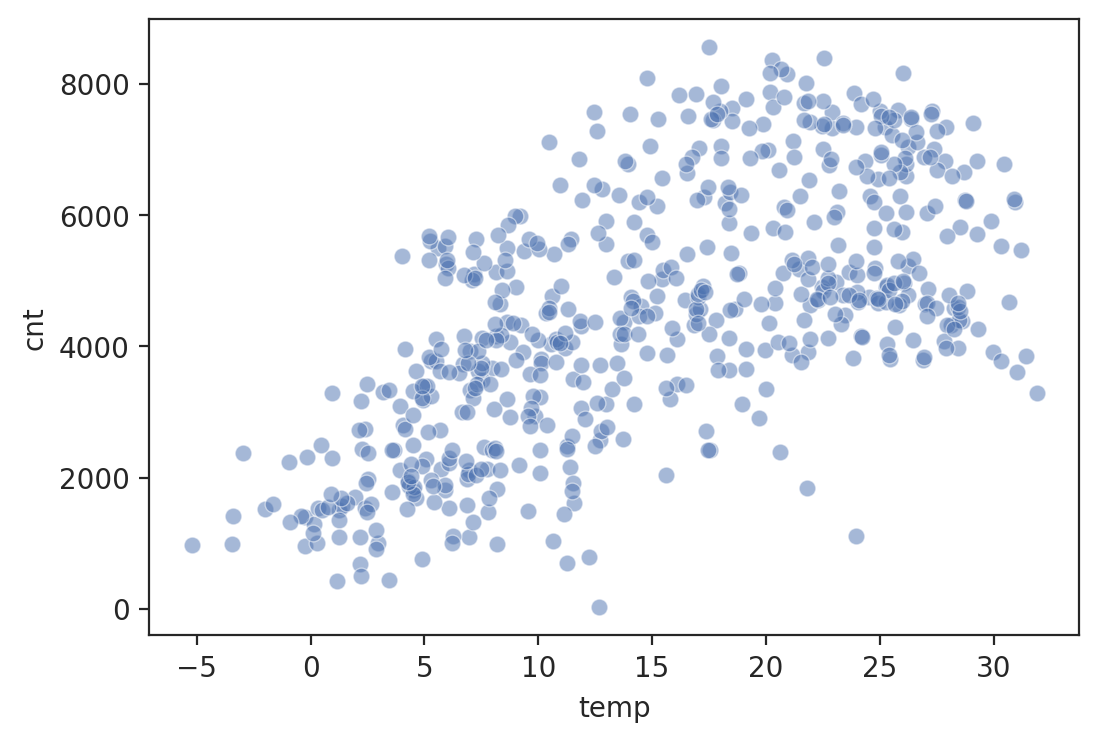

In [ ]:
sns.scatterplot(x=X_train['temp'], y=y_train, alpha=0.5);

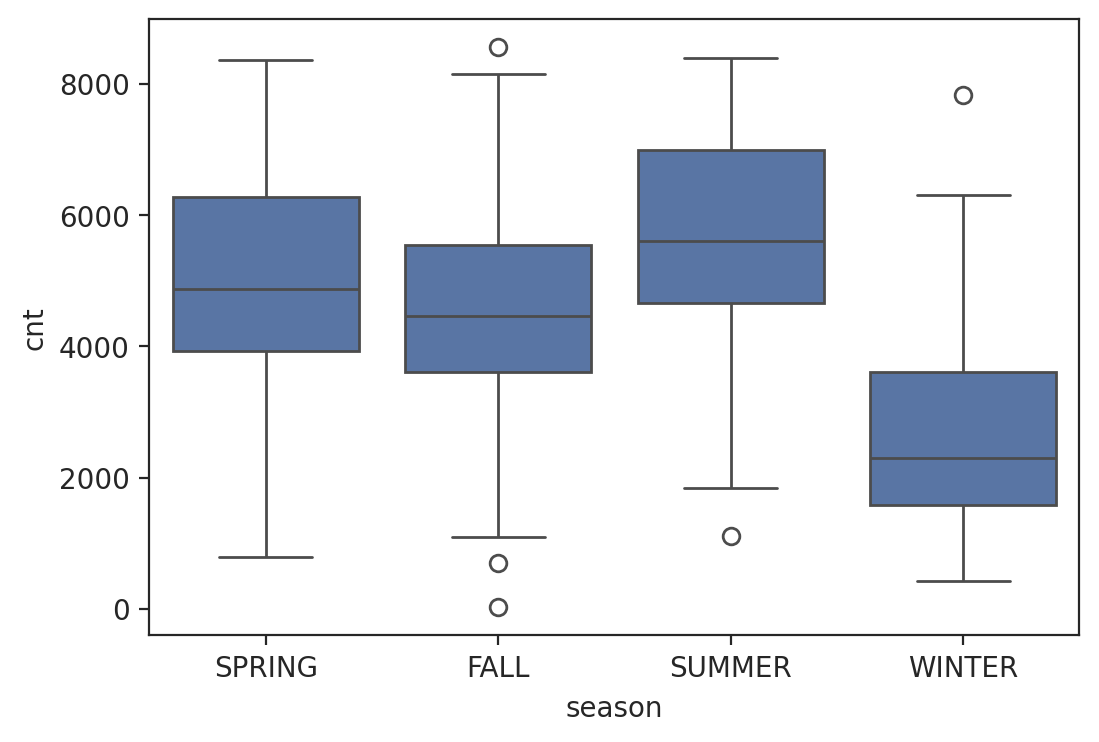

In [ ]:
sns.boxplot(x=X_train['season'], y=y_train);

## Visualising Predictions as a Function of the Features

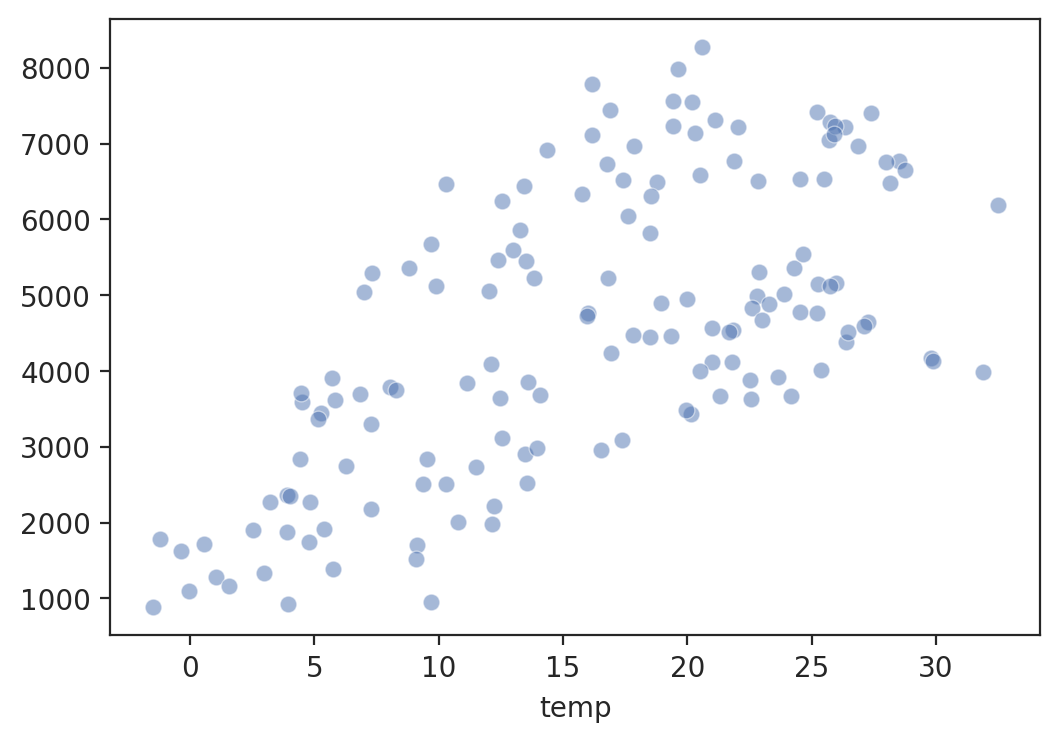

In [ ]:
sns.scatterplot(x=X_test['temp'], y=hgbr.predict(X_test), alpha=0.5);

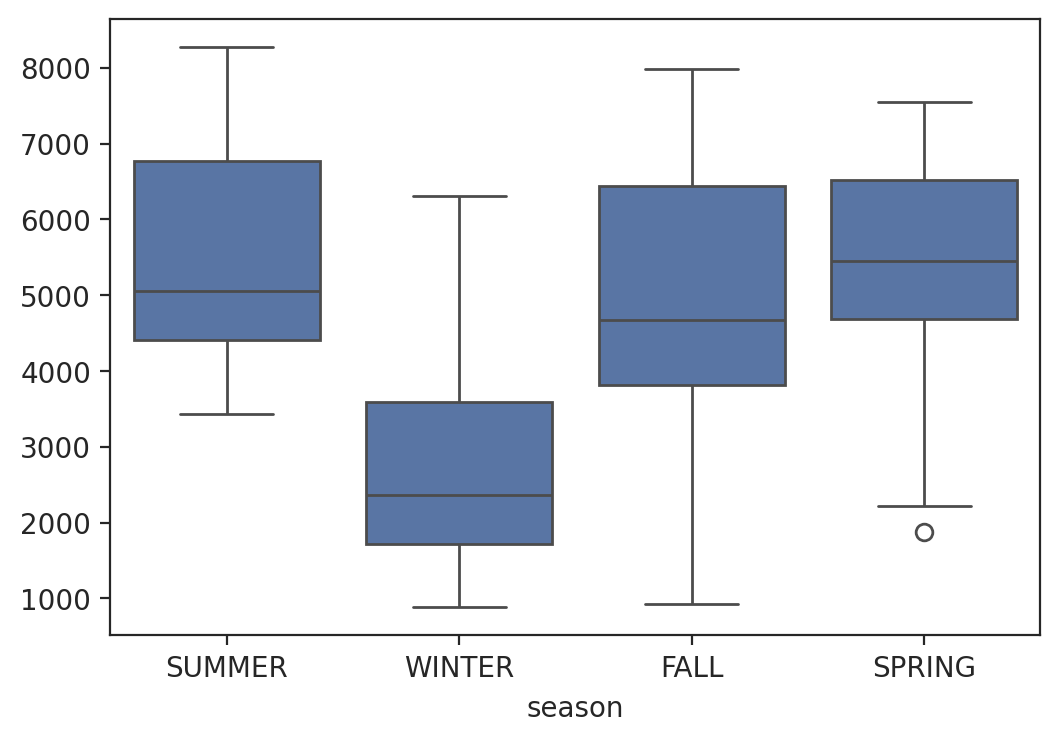

In [ ]:
sns.boxplot(x=X_test['season'], y=hgbr.predict(X_test));

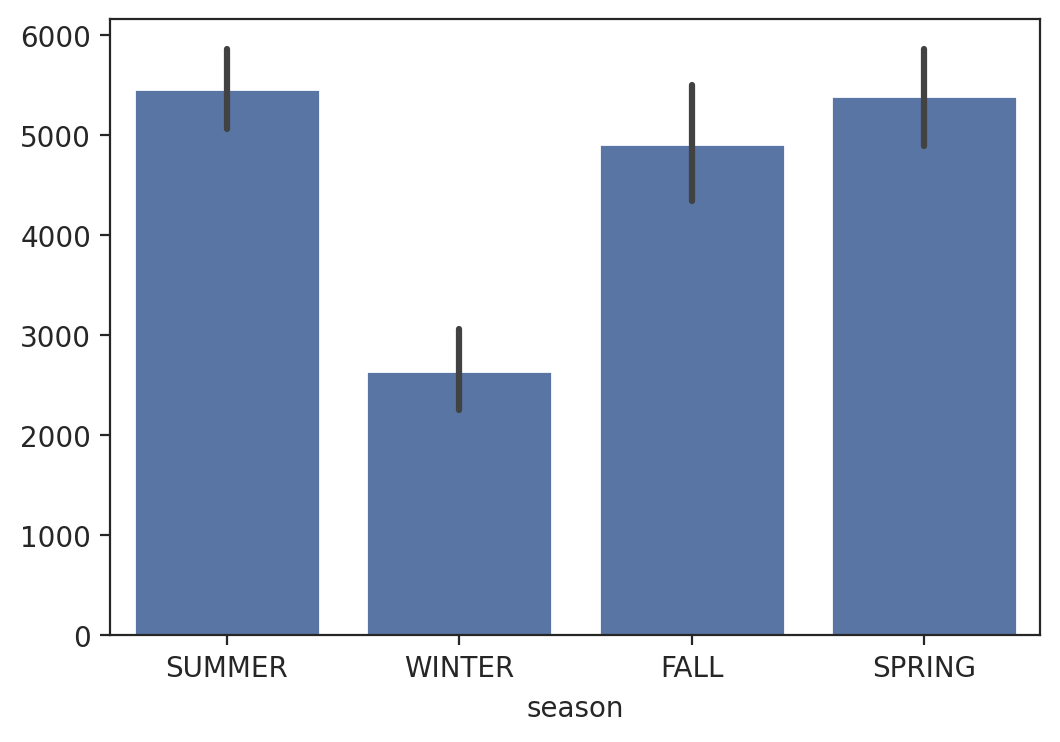

In [ ]:
sns.barplot(x=X_test['season'], y=hgbr.predict(X_test));

## PDPs/ICEs Plots

* Quantitative and Categorical
* 1D and 2D
* PDP (average), with added ICE (individual)

In [ ]:
X_test.columns

Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'hum', 'windspeed', 'days_since_2011'],
      dtype='object')

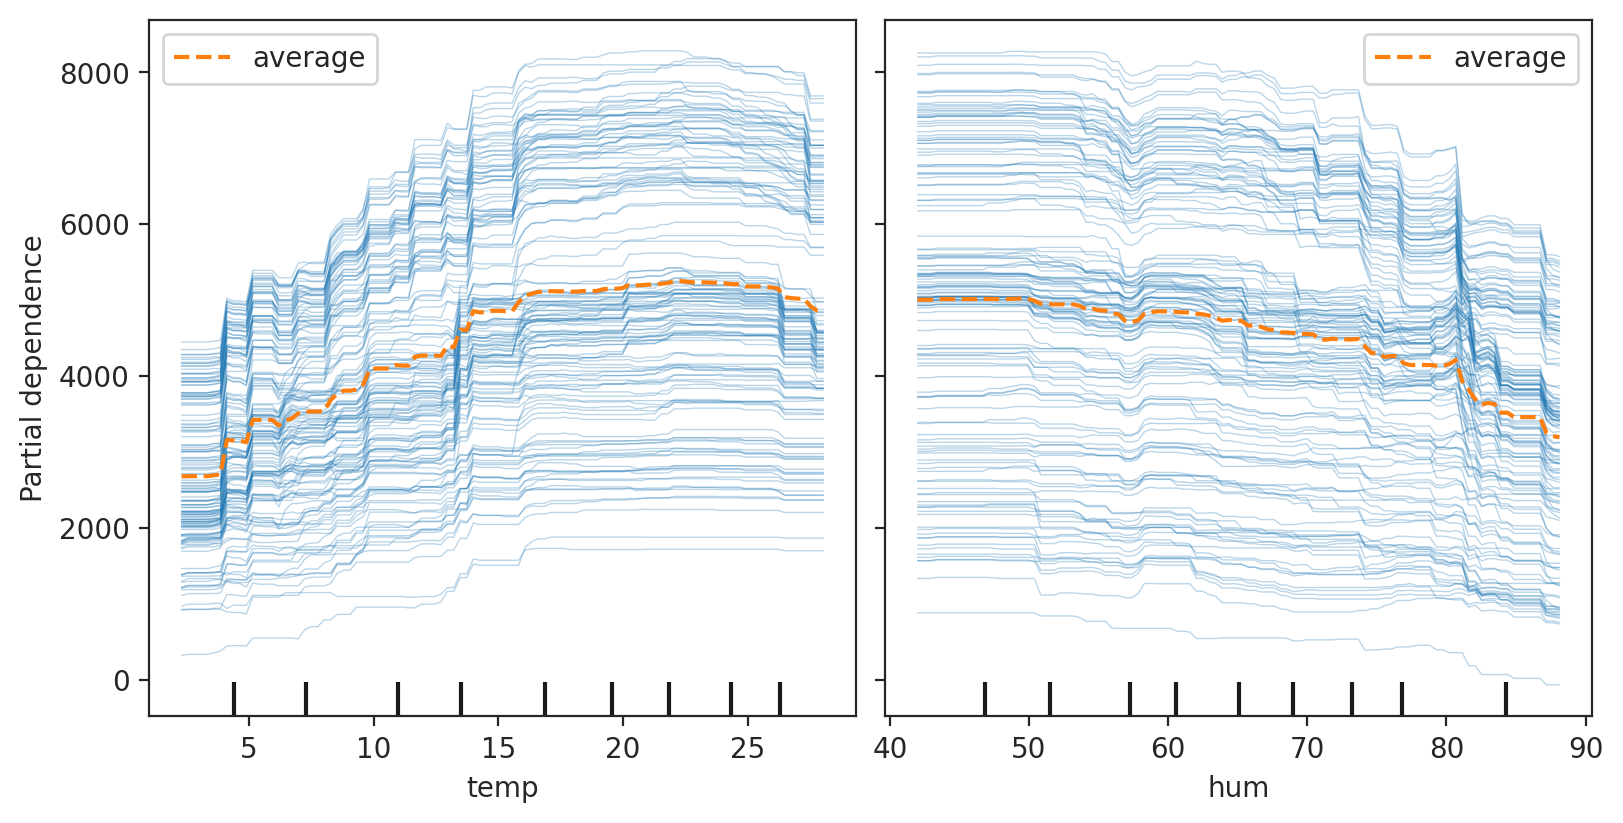

In [ ]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    hgbr, X_test, features=['temp', 'hum'],
    kind='both', ax=ax, n_cols=2
);

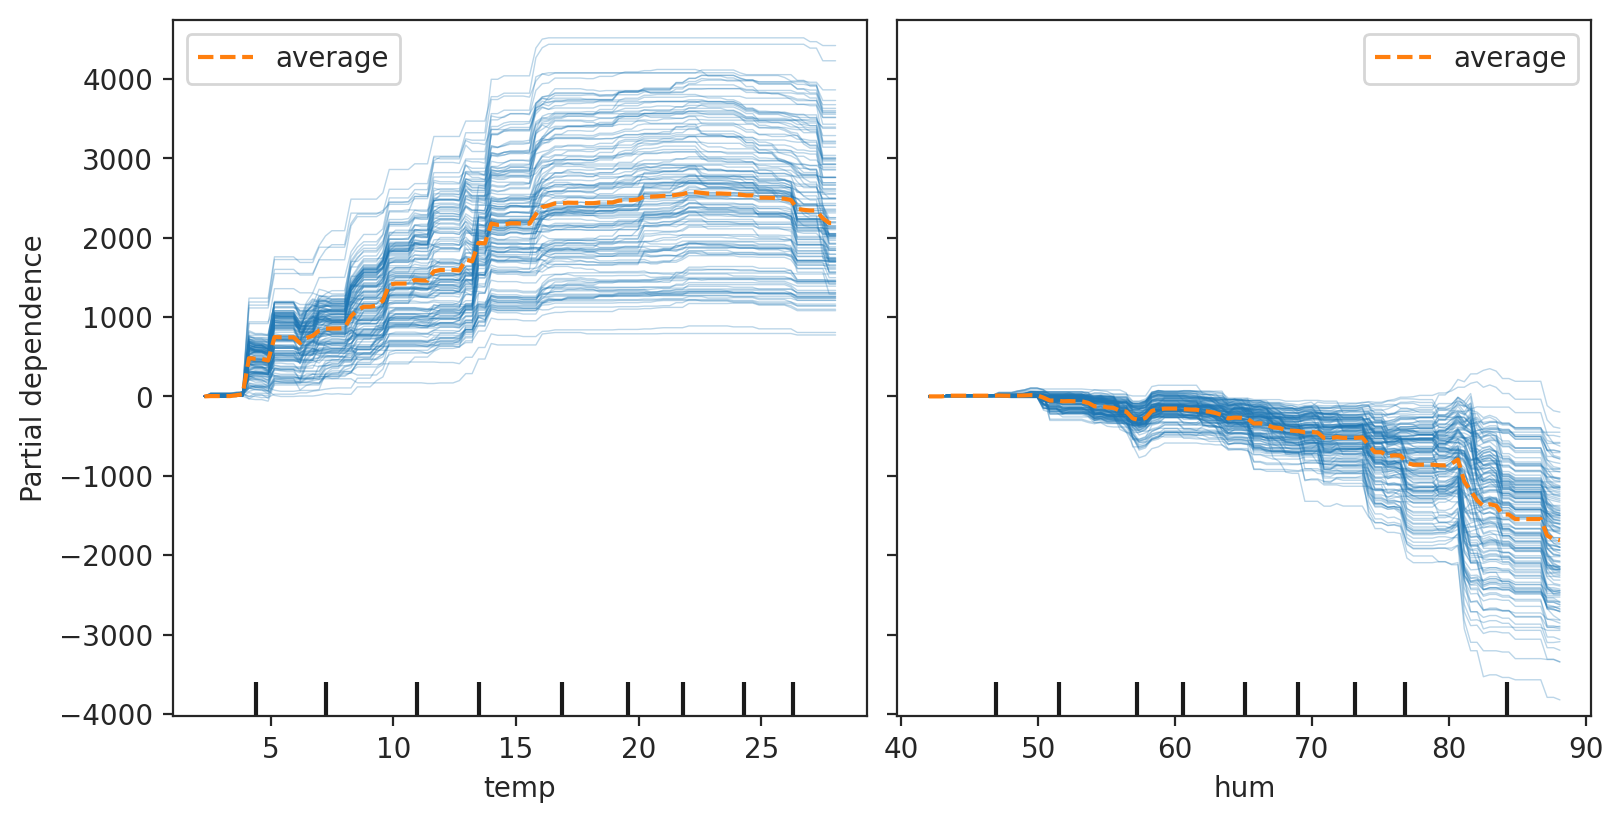

In [ ]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    hgbr, X_test, features=['temp', 'hum'],
    kind='both', ax=ax, n_cols=2, centered=True
);

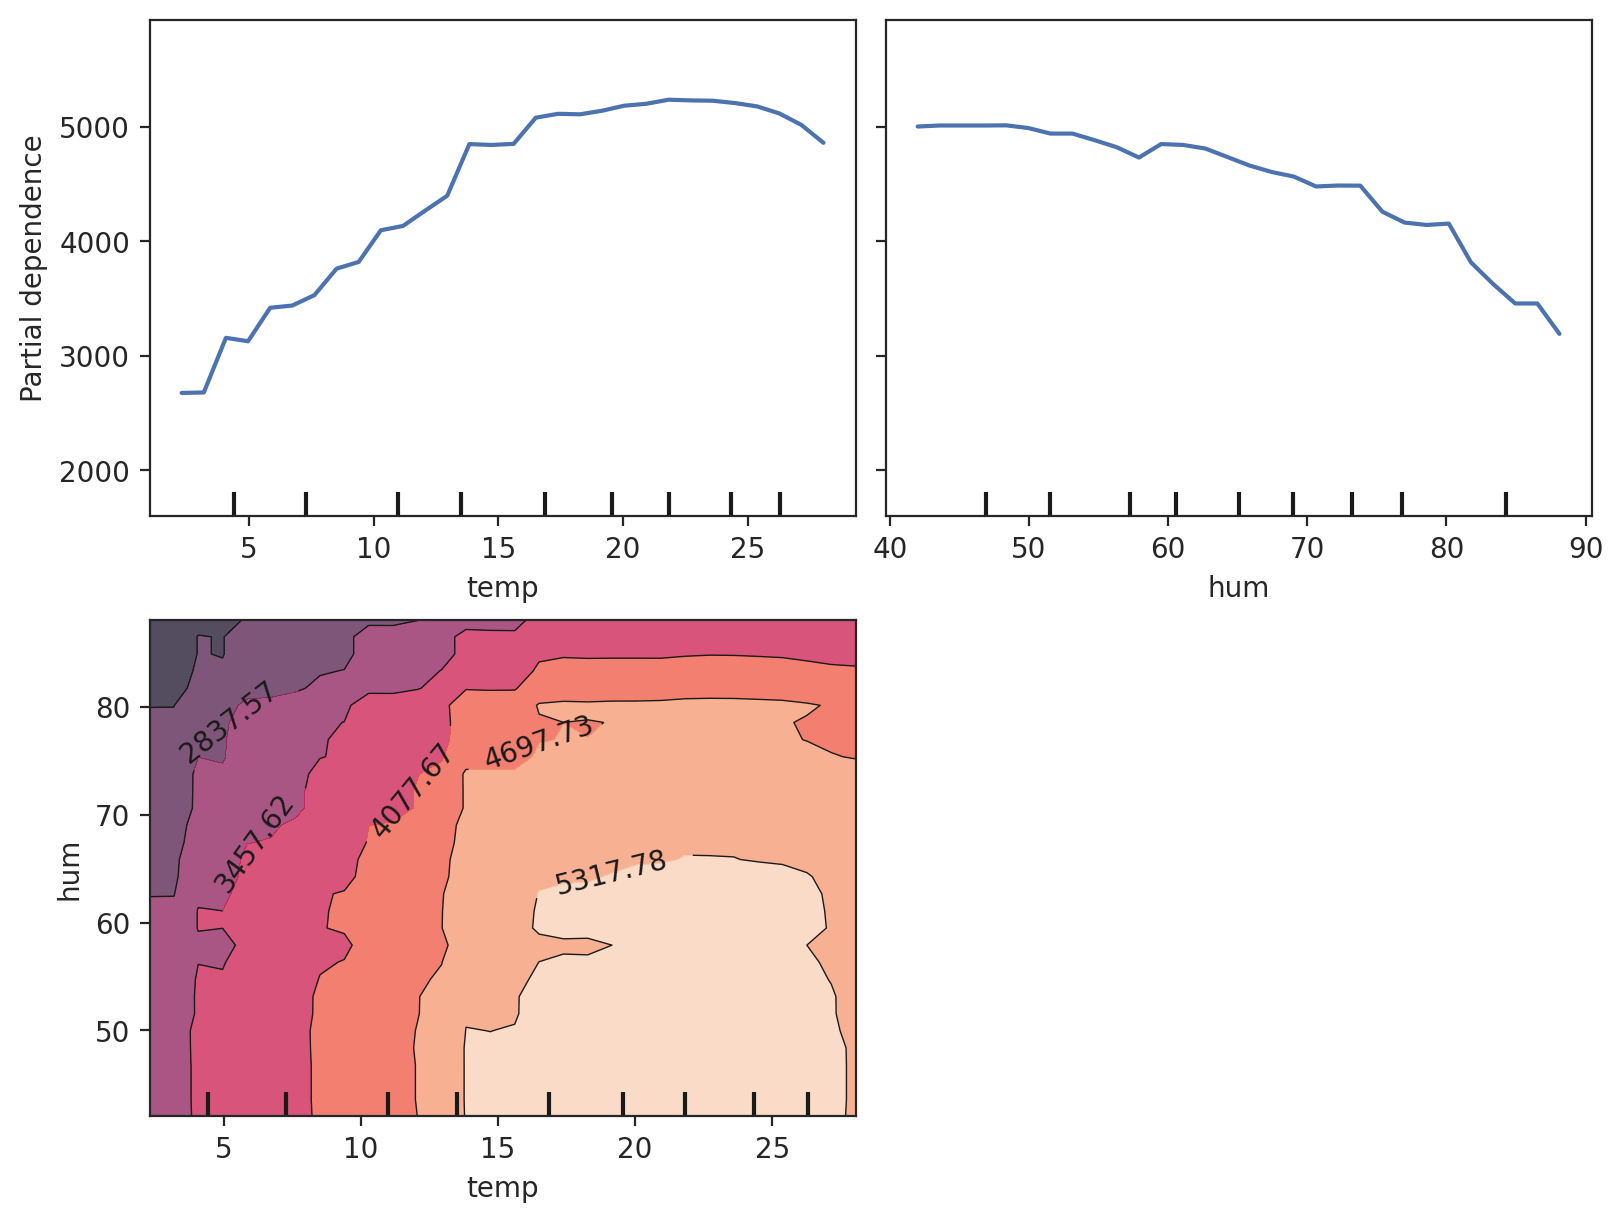

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    hgbr, X_test, features=['temp', 'hum', ('temp', 'hum')],
    kind='average',
    subsample=100, grid_resolution=30, random_state=0,
    ax=ax, n_cols=2
);

In [ ]:
X.columns

Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'hum', 'windspeed', 'days_since_2011'],
      dtype='object')

In [ ]:
# one-hot encoded feature: sex from titanic data
passenger = { 'sex': 0, 'fare': 22.7, 'pclass': 3}

In [ ]:
passenger

{'sex': 0, 'fare': 22.7, 'pclass': 3}

In [ ]:
passenger.update({ 'sex': 1})

In [ ]:
passenger

{'sex': 1, 'fare': 22.7, 'pclass': 3}

In [ ]:
X_test.head(1)

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
196,SUMMER,JUL,NO HOLIDAY,SAT,NO WORKING DAY,GOOD,24.273349,58.5,13.958914,196


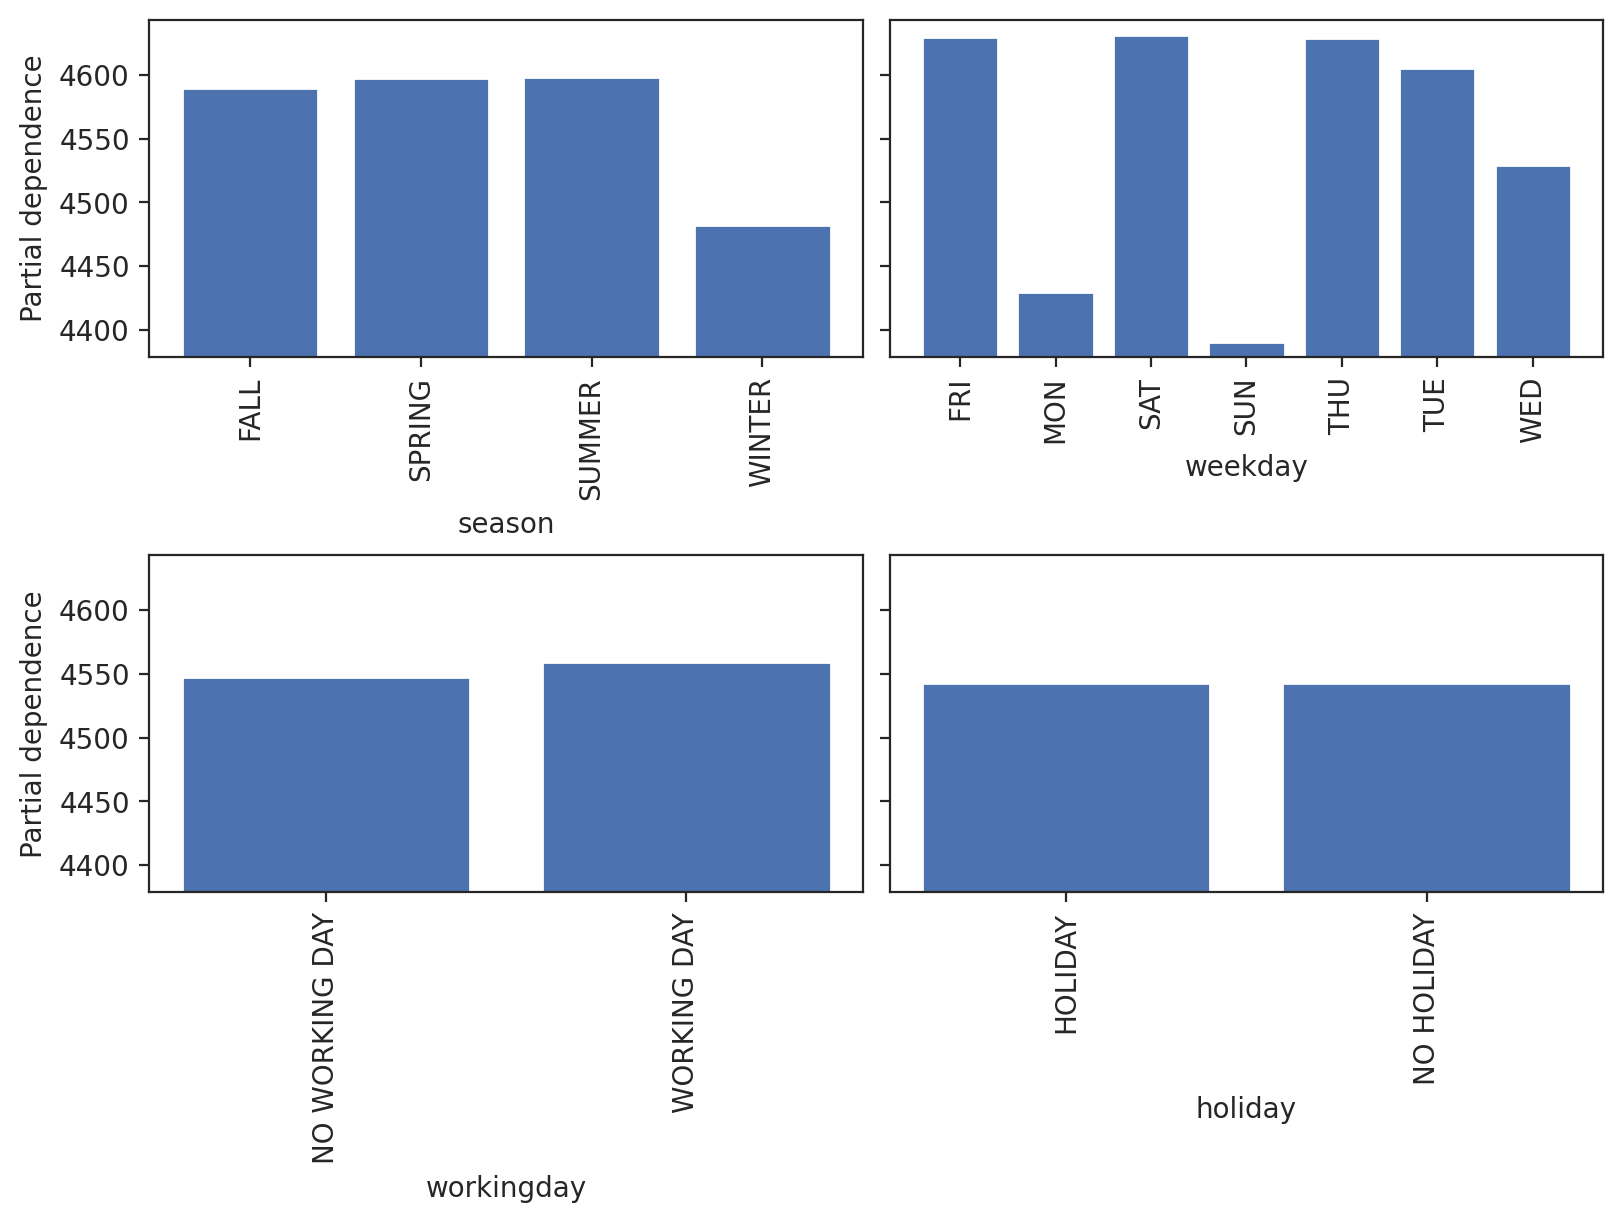

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    hgbr, X_test, features=['season', 'weekday', 'workingday', 'holiday'],
    categorical_features=['season', 'weekday', 'workingday', 'holiday'],
    kind='average', ax=ax, n_cols=2
);

* Boston bike ride dataset: why Mondays have lower demand?

Cross-referencing the model's behaviour with our training data...

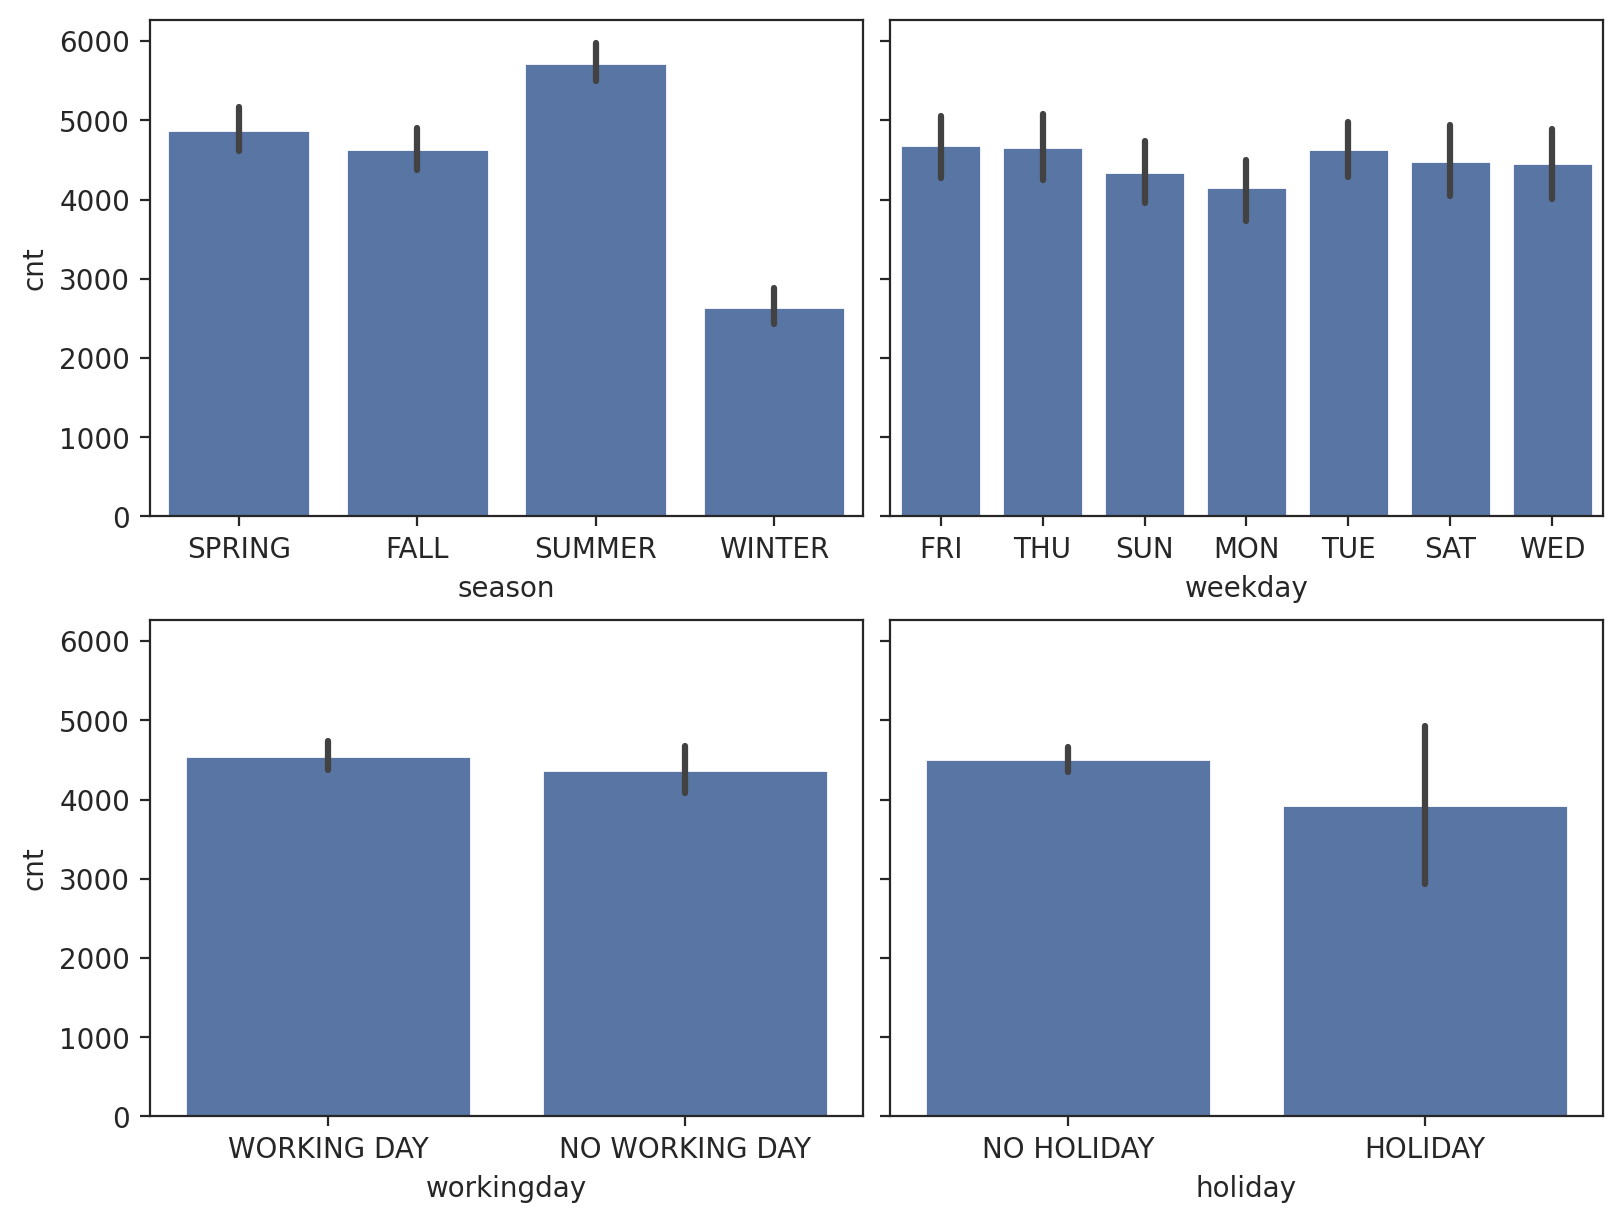

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8,6), constrained_layout=True, sharey=True)
sns.barplot(x=X_train['season'], y=y_train, ax=axs[0][0])
sns.barplot(x=X_train['weekday'], y=y_train, ax=axs[0][1])
sns.barplot(x=X_train['workingday'], y=y_train, ax=axs[1][0])
sns.barplot(x=X_train['holiday'], y=y_train, ax=axs[1][1]);

## PDPs/ICEs Values



In [ ]:
X_test.columns

Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
       'temp', 'hum', 'windspeed', 'days_since_2011'],
      dtype='object')

In [ ]:
pdv = partial_dependence(
    hgbr, X_test, features=['temp'], kind='both',
    grid_resolution=30
)

In [ ]:
pdv.keys()

dict_keys(['grid_values', 'values', 'average', 'individual'])

In [ ]:
pdv['individual'].shape

(1, 147, 30)

In [ ]:
X_test.shape

(147, 10)

In [ ]:
pdv['individual'][0][0]

array([2714.79291532, 2714.79291532, 3248.0875407 , 3271.38242874,
       3476.94683842, 3719.01623806, 3665.90920832, 3875.31995922,
       3875.31995922, 4218.00434633, 4204.85450608, 4265.53067753,
       4349.74172972, 5173.41309364, 5168.83697386, 5197.72284992,
       5236.14507664, 5222.86986819, 5215.820768  , 5216.74573928,
       5366.53712565, 5388.17945276, 5422.41194044, 5384.1052353 ,
       5375.9871294 , 5364.15587588, 5307.73175816, 5141.09171992,
       4875.20939134, 4574.37605708])

In [ ]:
pdv['grid_values'][0]

array([ 2.30247708,  3.18969368,  4.07691028,  4.96412688,  5.85134349,
        6.73856009,  7.62577669,  8.51299329,  9.40020989, 10.28742649,
       11.17464309, 12.0618597 , 12.9490763 , 13.8362929 , 14.7235095 ,
       15.6107261 , 16.4979427 , 17.3851593 , 18.2723759 , 19.15959251,
       20.04680911, 20.93402571, 21.82124231, 22.70845891, 23.59567551,
       24.48289211, 25.37010872, 26.25732532, 27.14454192, 28.03175852])

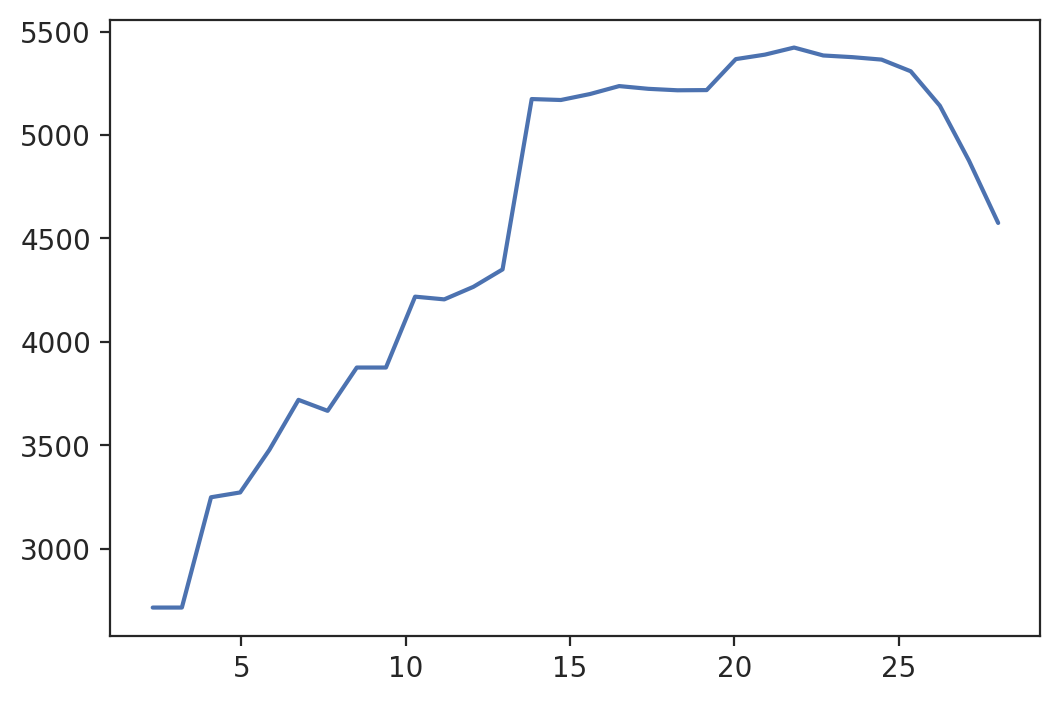

In [ ]:
# An ICE
sns.lineplot(y=pdv['individual'][0][0], x=pdv['grid_values'][0]);

In [ ]:
pdv2f = partial_dependence(
    hgbr, X_test, features=['temp', 'hum'], kind='both',
    grid_resolution=15
)

In [ ]:
pdv2f['individual'].shape

(1, 147, 15, 15)

In [ ]:
pdv2f['average'].shape

(1, 15, 15)

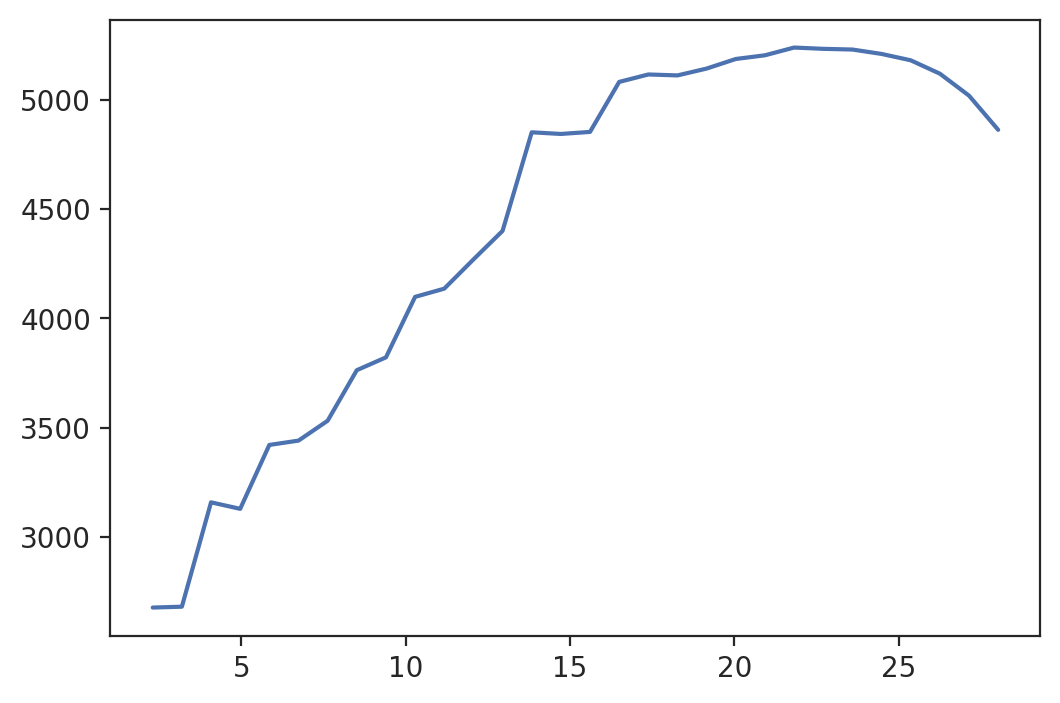

In [ ]:
# The PDP for feature 0 ('temp')
sns.lineplot(y=pdv['average'][0], x=pdv['grid_values'][0]);

## SHAP?!

In [ ]:
explainer = shap.TreeExplainer(hgbr['est'], hgbr['pp'].transform(X_train))

In [ ]:
shap_values = explainer(hgbr['pp'].transform(X_test))

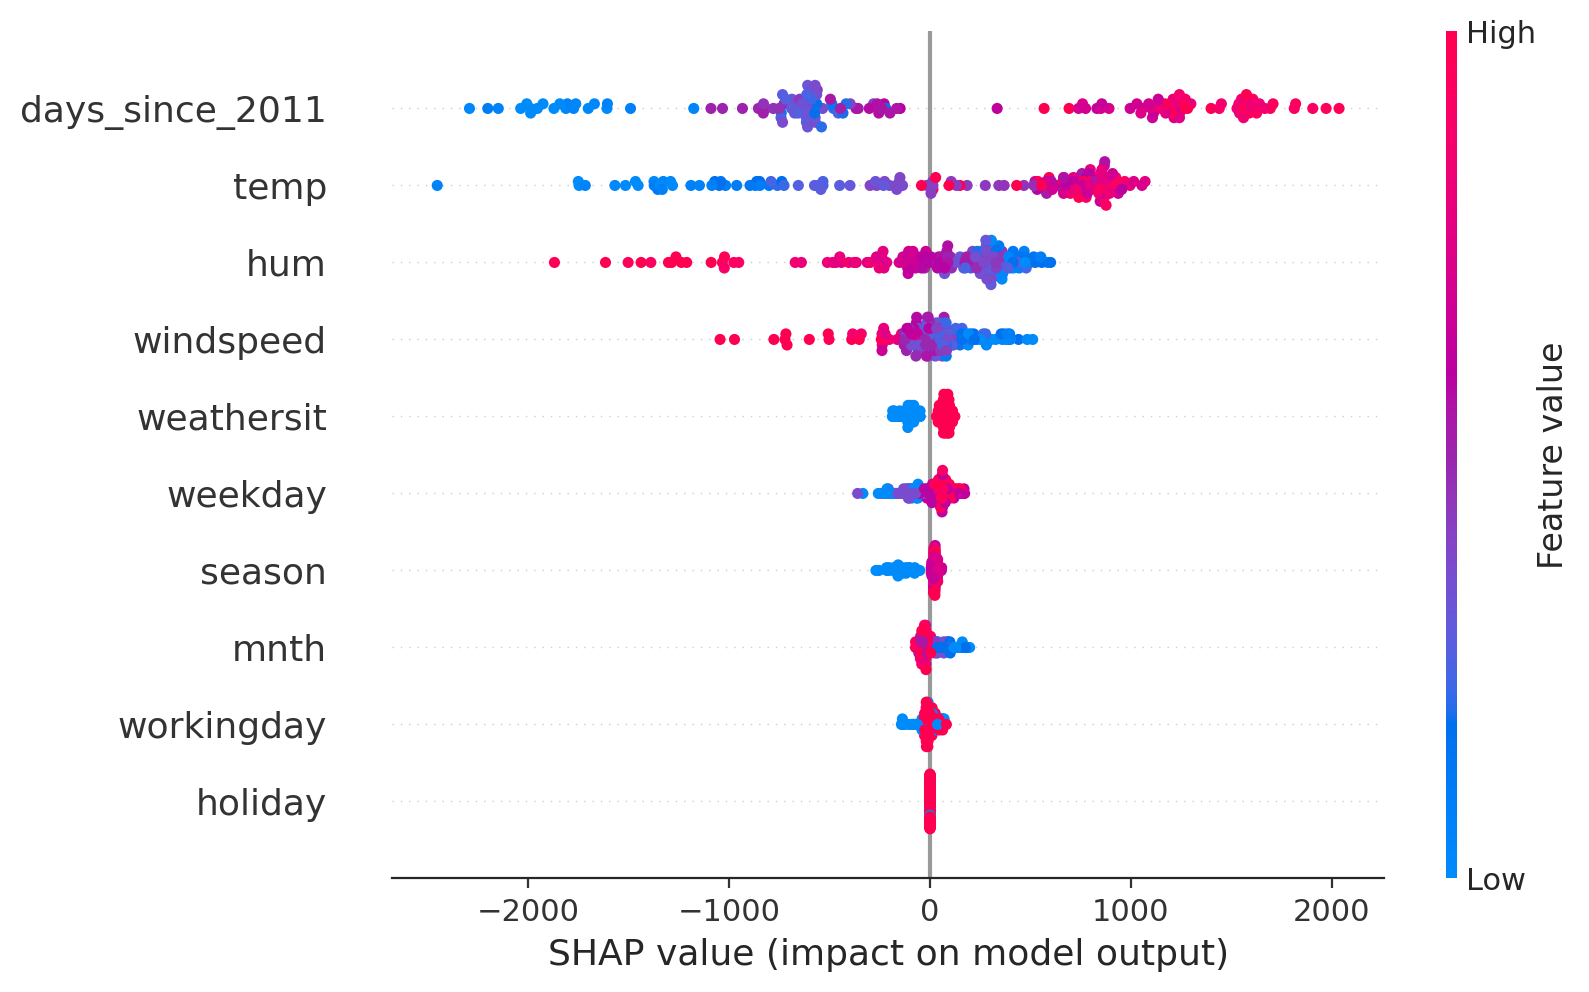

In [ ]:
shap.plots.beeswarm(shap_values)